# Comparing Models on the ExtraSensory dataset


## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

## Import modules

In [26]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow uses a basic train/test experiment to compare the use of several different Scikit-Learn classification models including a "guess the majority class" model, decision trees, logistic regression, RBF kernel SVMs, and KNN. The experiment uses the first 50,000  instances in the ExtraSensory data set. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation, and normalization. Next, the workflow includes one branch performing a train/test experiment for each model. Pre-processing is shared across all branches of the workflow. 

In the results below, we can see a 15% spread in accuracy across methods. However, the model hyper-parameters have not been optimized for any of the models, so the comparison is relatively meaningless. The hyper-parameters need to first be optimized before the models can be compared. This can be accomplished by wrapping the estimators in Scikit-Learns grid search cross-validation wrapper. See ExtraSensory-ComparingModels-NestedCV.ipynb for an example of nesting cross validation within experimental protocols. 

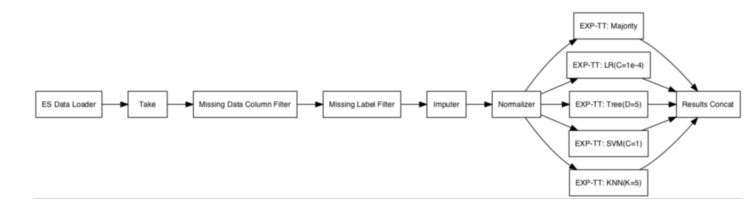

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Take

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 37895x221

Running step Normalizer
  Normalizer: running matrix of size 37895x221

Running step EXP-TT: KNN(K=5)
  Fitting and testing KNN(K=5)

Running step EXP-TT: SVM(C=1)
  Fitting and testing SVM(C=1)

Running step EXP-TT: Tree(D=5)
  Fitting and testing Tree(D=5)

Running step EXP-TT: LR(C=1e-4)
  Fitting and testing LR(C=1e-4)

Running step EXP-TT: Majority
  Fitting and testing Majority

Running step Results Concat
  Concatenating Results


,accuracy_score,f1_score,precision_score,recall_score
Majority,0.671809,0.000000,0.000000,0.000000
LR(C=1e-4),0.824379,0.692332,0.814418,0.602077
Tree(D=5),0.743834,0.412587,0.833749,0.274119
SVM(C=1),0.759440,0.537107,0.728806,0.425253
KNN(K=5),0.683828,0.369973,0.534607,0.282864



  Workflow complete



In [27]:
metrics     = [accuracy_score, f1_score, precision_score, recall_score]

df_raw      = extrasensory_data_loader(label="SLEEPING");
df_raw      = Take(df_raw, 50000)
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

models = {
              "Majority":   DummyClassifier(strategy="most_frequent"),
              "LR(C=1e-4)": LogisticRegression(C=1e-4, solver="lbfgs",max_iter=1000),
              "Tree(D=5)":  tree.DecisionTreeClassifier(max_depth=5),
              "SVM(C=1)":   SVC(C=1, gamma="auto", max_iter=1000),
              "KNN(K=5)":   KNeighborsClassifier(5)
        }

res     = ExpTrainTest(df_norm, models, metrics=metrics);
res_cat = ResultsConcat(res)
flow    = workflow(res_cat)
 
flow.draw(); plt.show();
output=flow.run();